## Goals



-   Load raw and hypnogram data
-   Plot time series
-   Plot spectrogram
-   Plotting stages of sleep
-   Spetral analysis of different sleep stages
-   EOG analysis
-   Connectivity analysis



## Basic setup



This imports the libraries needed for this analysis.



In [1]:
import pyedflib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

%matplotlib inline

Nicer defaults for plots



In [1]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 4)

## Load the data



Let&rsquo;s load the signals first. They&rsquo;re stored in an EDF file, so we need to use the pyedflib library.



In [1]:
file_name = '/home/pierre/data/neurotech/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001E0-PSG.edf'
f_signals = pyedflib.EdfReader(file_name)

Let&rsquo;s see what signals we have accesss to, along with their index in the EDF file.



In [1]:
signal_labels = f_signals.getSignalLabels()
for i, label in enumerate(signal_labels):
    print(i, label)

0 EEG Fpz-Cz
1 EEG Pz-Oz
2 EOG horizontal
3 Resp oro-nasal
4 EMG submental
5 Temp rectal
6 Event marker

For convenience, we load the data into a dictionary.



In [1]:
data = dict()
for i, label in enumerate(signal_labels):
    data[label] = f_signals.readSignal(i)

Next, in this dataset, some experts also annotated the transitions between sleep stages. We load these as well.



In [1]:
file_name = '/home/pierre/data/neurotech/sleep-edf-database-expanded-1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf'
f_stages = pyedflib.EdfReader(file_name)
stage_t, stage_dt, stage_names = f_stages.readAnnotations()

Let&rsquo;s print the first 10 transitions as an example



In [1]:
for t, name in zip(stage_t[:10], stage_names[:10]):
    print(t, name)

0.0 Sleep stage W
30630.0 Sleep stage 1
30750.0 Sleep stage 2
31140.0 Sleep stage 3
31170.0 Sleep stage 2
31200.0 Sleep stage 3
31350.0 Sleep stage 4
31380.0 Sleep stage 3
31440.0 Sleep stage 4
31500.0 Sleep stage 3

## Plotting data



Let&rsquo;s start by plotting the full EEG data for the Fpz-Cz channel.



Text(0, 0.5, 'EEG voltage')

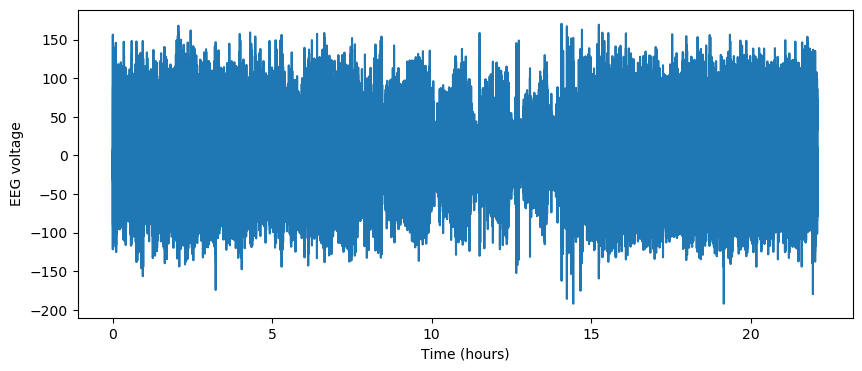

In [1]:
t = np.arange(data['EEG Fpz-Cz'].shape[0]) / (100 * 60 * 60) # time in hours
plt.plot(t, data['EEG Fpz-Cz'])
plt.xlabel('Time (hours)')
plt.ylabel('EEG voltage')

That&rsquo;s a lot of data! Let&rsquo;s zoom in on only a little chunk.



Text(0, 0.5, 'EEG voltage')

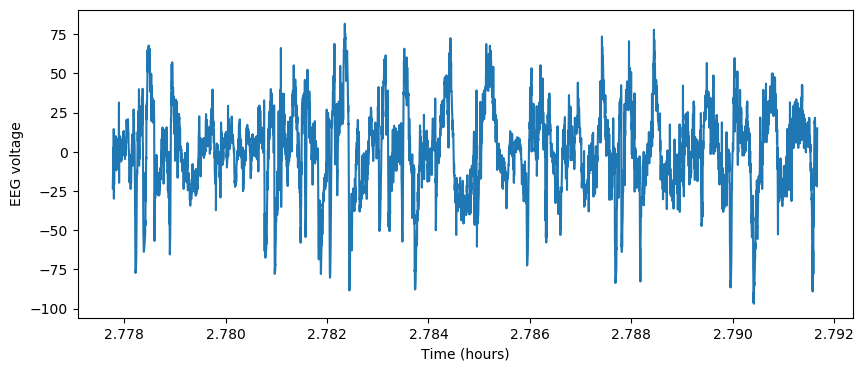

In [1]:
chunk = np.arange(1000000,1005000)

t = np.arange(data['EEG Fpz-Cz'].shape[0]) / (100 * 60 * 60) # time in hours
plt.plot(t[chunk], data['EEG Fpz-Cz'][chunk])
plt.xlabel('Time (hours)')
plt.ylabel('EEG voltage')

We see that there are little oscillations in the signal. We can quantify this by decomposing the signal into its component oscillations and measuring the amplitude of each frequency. Here&rsquo;s how to do that for the whole signal.
When we do this, we see a small peak at sligthly above 10 Hz, these are likely alpha waves from Stage 1 NREM sleep.



Text(0.5, 0, 'Frequency (Hz)')

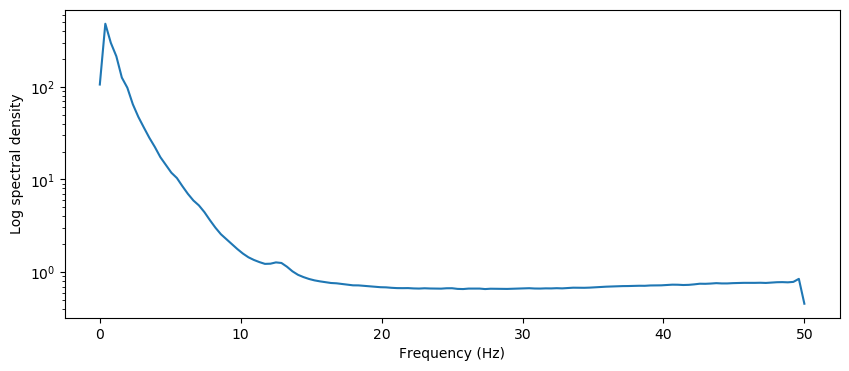

In [1]:
f, Pxx = signal.welch(data['EEG Fpz-Cz'], fs=100)
plt.semilogy(f, Pxx)
plt.ylabel('Log spectral density')
plt.xlabel('Frequency (Hz)')

It would be more useful to see frequency power over time, rather than for the whole signal at once, so that we can see changes.
We can do this with a spectrogram, which computes frequency power in little signal chunks. We can plot it as a heatmap below.

At around 30000 seconds, the person falls asleep. Can you see the change in the frequency distribution?



Text(0.5, 0, 'Time (s)')

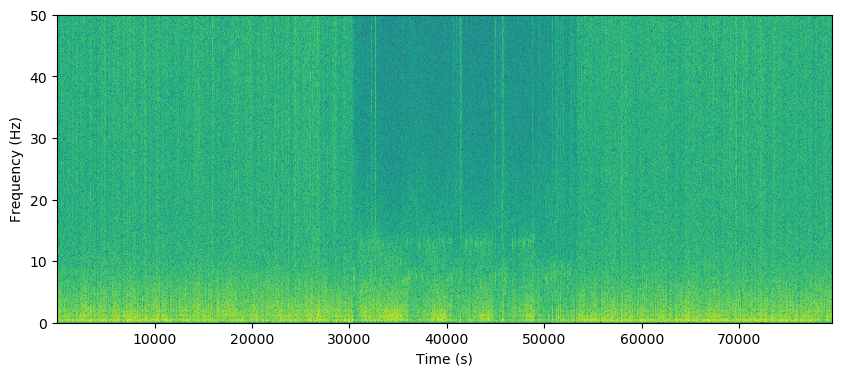

In [1]:
_ = plt.specgram(data['EEG Fpz-Cz'], Fs=100, NFFT=1024, noverlap=128)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')

As before, we can plot only a chunk of this. We zoom in on the region where the person falls asleep.



Text(0.5, 0, 'Time (s)')

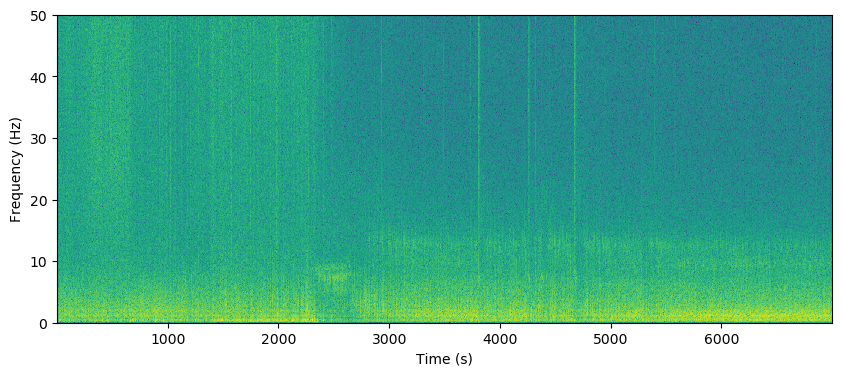

In [1]:
chunk = np.arange(2800000, 3500000)
_ = plt.specgram(data['EEG Fpz-Cz'][chunk], Fs=100, NFFT=1024, noverlap=128)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')

## Sleep stages



To make it more interesting, we can consider the metadata a bit more. Recall that these are the first 10 transitions.
The time is in seconds.



In [1]:
for t, name in zip(stage_t[:10], stage_names[:10]):
    print(t, name)

0.0 Sleep stage W
30630.0 Sleep stage 1
30750.0 Sleep stage 2
31140.0 Sleep stage 3
31170.0 Sleep stage 2
31200.0 Sleep stage 3
31350.0 Sleep stage 4
31380.0 Sleep stage 3
31440.0 Sleep stage 4
31500.0 Sleep stage 3

Let&rsquo;s load these into an array using a simple integer mapping so we can plot it later.



In [1]:
stage_map = {
    'Sleep stage W': -1,
    'Sleep stage R': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 4,
}

map_stage = {v: k for k, v in stage_map.items()}

sleep_stages = np.zeros(data['EEG Fpz-Cz'].shape, dtype='int32')
sleep_stages[:] = -1

for a, b, name in zip(stage_t, stage_t[1:], stage_names):
    a = int(a)*100
    b = int(b)*100
    sleep_stages[a:b] = stage_map[name]

Text(0.5, 0, 'Time (hours)')

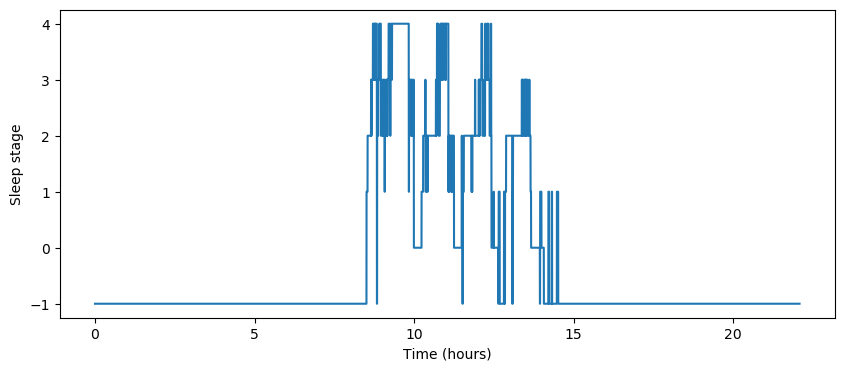

In [1]:
t = np.arange(data['EEG Fpz-Cz'].shape[0]) / (100 * 60 * 60) # time in hours
plt.plot(t, sleep_stages)
plt.ylabel('Sleep stage')
plt.xlabel('Time (hours)')

Let&rsquo;s try to plot some frequency plots for each stage.
You can see the differences in frequencies for each stage! They map nicely to the expected frequencies.



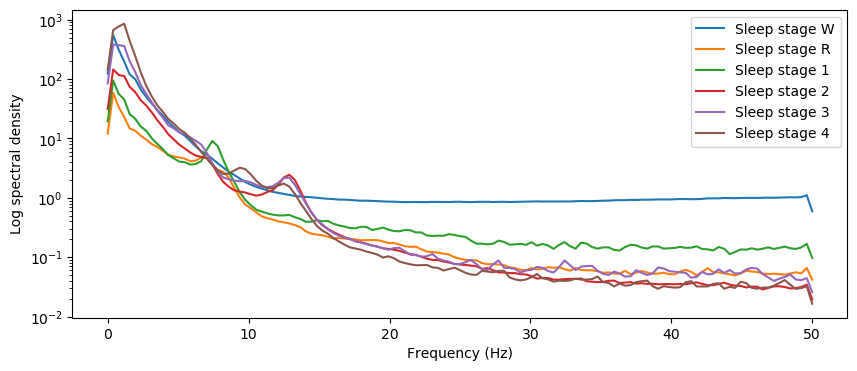

In [1]:
for name, stage_id in stage_map.items():
    check = sleep_stages == stage_id
    eeg_sub = data['EEG Fpz-Cz'][check]
    f, Pxx = signal.welch(eeg_sub, fs=100)
    plt.semilogy(f, Pxx, label=name)
plt.ylabel('Log spectral density')
plt.xlabel('Frequency (Hz)')
plt.legend()

## Analysis of eye movement



## Coherence of brainwaves

